In [31]:
import numpy as np
import matplotlib.pyplot as plt

class SplitNode:
    def __init__(self, upper_left, lower_right, direction, split_position, original_image, min_ratio, depth=0):
        self.upper_left     = upper_left   # (row, col) coordinates of the upper-left corner of the region
        self.lower_right    = lower_right  # (row, col) coordinates of the lower-right corner of the region
        self.direction      = direction    # 'horizontal' or 'vertical'
        self.split_position = split_position  # Position of the split (row or column)
        self.original_image = original_image  # The full original image
        self.min_ratio      = min_ratio  # Minimum ratio of the sum for meaningful splits
        self.depth          = depth  # Depth of the node in the tree (for visualization and control)
        self.left           = None  # Left child (first part of the split)
        self.right          = None  # Right child (second part of the split)

    def split(self, border_margin_ratio=0, min_size=(10, 10)):
        """ Recursively split the image region and create child nodes, but conserve original image """
        # Analyze the current image to decide on the split direction and position
        result = self.analyze_image(border_margin_ratio)
        print(result)
        # Stop recursion if the split does not meet the ratio or image is too small
        if (self.lower_right[0] - self.upper_left[0] <= min_size[0] or
            self.lower_right[1] - self.upper_left[1] <= min_size[1] or
            result['ratio'] < self.min_ratio):
            return None
        
        # Perform the split based on the result
        direction      = result['direction']
        split_position = result['min_position']

        # Create new split nodes for the left and right children with updated coordinates
        if direction == 'horizontal':
            split1_upper_left = self.upper_left
            split1_lower_right = (self.upper_left[0] + split_position, self.lower_right[1])
            split2_upper_left = (self.upper_left[0] + split_position, self.upper_left[1])
            split2_lower_right = self.lower_right
        else:
            split1_upper_left = self.upper_left
            split1_lower_right = (self.lower_right[0], self.upper_left[1] + split_position)
            split2_upper_left = (self.upper_left[0], self.upper_left[1] + split_position)
            split2_lower_right = self.lower_right

        # Create the left and right child nodes, but still refer to the original image
        self.left = SplitNode(split1_upper_left, split1_lower_right, direction, split_position, self.original_image, self.min_ratio, self.depth + 1)
        self.right = SplitNode(split2_upper_left, split2_lower_right, direction, split_position, self.original_image, self.min_ratio, self.depth + 1)

        # Recursively split the child nodes
        self.left.split(border_margin_ratio, min_size)
        self.right.split(border_margin_ratio, min_size)
        
        return self

    def get_split_region(self):
        """ Get the region of the original image that corresponds to this node. """
        return self.original_image[self.upper_left[0]:self.lower_right[0], self.upper_left[1]:self.lower_right[1]]

    def analyze_image(self, border_margin_ratio=0):
        """ Analyze the image to find the best split direction and position. """
        # Sum of pixels by row and by column
        sum_rows    = np.sum(self.get_split_region(), axis=1)
        sum_columns = np.sum(self.get_split_region(), axis=0)
        print(self.get_split_region())
        print([sum_rows, sum_columns])
        # Define the border margin in pixels
        print(self.get_split_region().shape)
        rows, cols = self.get_split_region().shape
        border_margin_row = int(rows * border_margin_ratio)
        border_margin_col = int(cols * border_margin_ratio)
        
        # Ensure that we don't try to compute differences on an empty array
        if rows - 2 * border_margin_row <= 0 or cols - 2 * border_margin_col <= 0:
            raise ValueError("The border margin is too large, resulting in empty slices.")

        # Exclude borders by masking out the border region
        sum_rows_within    = sum_rows[border_margin_row:rows-border_margin_row]
        sum_columns_within = sum_columns[border_margin_col:cols-border_margin_col]

        # Check that the remaining slices are non-empty
        if len(sum_rows_within) < 2 or len(sum_columns_within) < 2:
            raise ValueError("Not enough pixels to compute meaningful differences.")

        # Calculate the difference between consecutive sums (to find transition regions)
        row_diff = np.abs(np.diff(sum_rows_within))  # Difference between consecutive row sums
        col_diff = np.abs(np.diff(sum_columns_within))  # Difference between consecutive column sums
        
        # Ensure there is at least one difference to compute argmax
        if len(row_diff) == 0 or len(col_diff) == 0:
            raise ValueError("Not enough variation in the image to compute a split.")

        # Find the indices of the largest differences (indicating a transition)
        row_split_position = np.argmax(row_diff) + border_margin_row  # + border_margin_row to correct the shift
        col_split_position = np.argmax(col_diff) + border_margin_col  # + border_margin_col to correct the shift
        
        # Calculate ratios for row and column splits
        min_row_value = np.min(sum_rows_within)
        max_row_value = np.max(sum_rows_within)
        row_ratio = min_row_value / max_row_value if max_row_value != 0 else float('inf')
        
        min_col_value = np.min(sum_columns_within)
        max_col_value = np.max(sum_columns_within)
        col_ratio = min_col_value / max_col_value if max_col_value != 0 else float('inf')

        # Choose the split direction based on the ratio comparison and proximity to the center
        if row_ratio > col_ratio:
            direction = 'horizontal'
            split_position = row_split_position
        else:
            direction = 'vertical'
            split_position = col_split_position
        
        # Return the analysis result
        return {
            'direction': direction,
            'min_position': split_position,
            'min_value': min_row_value if direction == 'horizontal' else min_col_value,
            'max_value': max_row_value if direction == 'horizontal' else max_col_value,
            'ratio': row_ratio if direction == 'horizontal' else col_ratio
        }

    def print_tree(self, level=0):
        """ Print the tree in a text-based format. """
        indent = '  ' * level
        print(f"{indent}Node at {self.upper_left} - {self.lower_right} - {self.direction} split at position {self.split_position} (Ratio: {self.min_ratio})")
        if self.left:
            self.left.print_tree(level + 1)
        if self.right:
            self.right.print_tree(level + 1)

    def plot(self):
        """ Plot the original image and the splits with hlines and vlines. """
        fig, ax = plt.subplots()
        ax.imshow(self.original_image, cmap='gray', interpolation='nearest')
        
        # Plot vertical and horizontal lines for splits
        self._plot_splits(ax)
        
        plt.show()

    def _plot_splits(self, ax):
        """ Recursively plot the splits from this node. """
        if self.left:
            self.left._plot_splits(ax)
        if self.right:
            self.right._plot_splits(ax)

        # Plot horizontal and vertical lines for this node's split
        if self.direction == 'horizontal':
            ax.axhline(y=self.upper_left[0] + self.split_position, color='r', linestyle='--')
        elif self.direction == 'vertical':
            ax.axvline(x=self.upper_left[1] + self.split_position, color='r', linestyle='--')



In [28]:
# Example image (binary image with black and white regions)
image = np.array([[0,     0,   0, 255, 255, 255],
                  [0,     0,   0, 255, 255, 255],
                  [0,     0,   0, 255, 255, 255],
                  [255, 255, 255,   0,   0, 0],
                  [255, 255, 255,   0,   0, 0],
                  [255, 255, 255,   0,   0, 0]])

# Create the root node for the entire image
root = SplitNode((0, 0), (image.shape[0], image.shape[1]), 'horizontal', 0, image, min_ratio=0.2)

In [13]:
root.depth

0

In [ ]:
# Recursively split the image
root.split(border_margin_ratio=0.1, min_size=(3, 3))


In [ ]:
# Print the resulting split tree in text format
root.print_tree()
# Plot the splits on the original image
root.plot()

[[255 255 255 255 255 255   0   0   0   0]
 [255 255 255 255 255 255   0   0   0   0]
 [255 255 255 255 255 255   0   0   0   0]
 [  0   0   0   0   0   0 255 255 255 255]
 [  0   0   0   0   0   0 255 255 255 255]
 [  0   0   0   0   0   0 255 255 255 255]
 [255 255 255 255 255 255   0   0   0   0]
 [255 255 255 255 255 255   0   0   0   0]
 [255 255 255 255 255 255   0   0   0   0]
 [  0   0   0   0   0   0 255 255 255 255]]
[array([1530, 1530, 1530, 1020, 1020, 1020, 1530, 1530, 1530, 1020]), array([1530, 1530, 1530, 1530, 1530, 1530, 1020, 1020, 1020, 1020])]
(10, 10)
{'direction': 'vertical', 'min_position': 5, 'min_value': 1020, 'max_value': 1530, 'ratio': 0.6666666666666666}
[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [  0   0   0   0   0]]
[array([1275, 1275, 1275,    0,    0,    0, 1275, 1275, 1275,    0]), array([1

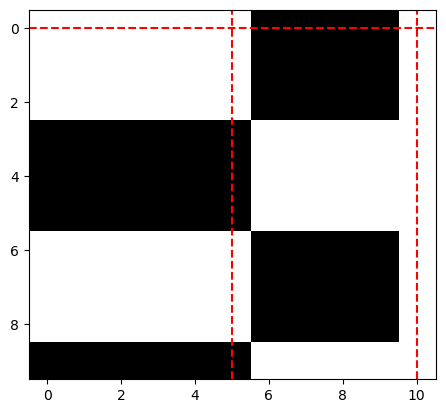

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create a more complex image with clear transition regions
image = np.array([
    [255, 255, 255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 255, 255, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 255, 255, 255, 255],
    [0, 0, 0, 0, 0, 0, 255, 255, 255, 255],
    [0, 0, 0, 0, 0, 0, 255, 255, 255, 255],
    [255, 255, 255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 255, 255, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 255, 255, 255, 255]
])

# Now the image has black regions (0) and white regions (255) with a clear boundary in the middle

# Create the root node for the entire image
root = SplitNode((0, 0), (image.shape[0], image.shape[1]), 'horizontal', 0, image, min_ratio=0.2)

# Recursively split the image
root.split(border_margin_ratio=0.1, min_size=(5, 5))

# Print the resulting split tree in text format
root.print_tree()

# Plot the splits on the original image
root.plot()
